# MIND2 Benchmarking

This repository benchmarks __MIND2__ ("Monitoring IoT Networks with Digital Twins") using linear regressions. The benchmark involves four main performance indicators: throughput, latency, CPU, and RAM. The benchmark process and theory is grounded on the theory from [Sedlmeir et al. (2021)](https://aisel.aisnet.org/hicss-54/st/blockchain_engineering/4/). The overall objective is the identification of the sustainable throughput. 

> *As long as the frequency of requests equals the frequency of responses, the throughput is sustainable.* 

## Defining elementary functions for data extraction, aggregation, plotting

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import namedtuple

In [30]:
# adopted from https://github.com/DLPS-Framework/ChainLab/blob/31d6ebd466f20eeb7ec99c36f01e0fec00a0cc5f/src/benchmarking/benchmarking.py
def plot_chart(runs,qos):

    base_size = 8
    nice_fonts = {
        "text.usetex": False,
        "axes.labelsize": base_size + 2,
        "font.size": base_size + 2,
        "legend.fontsize": base_size,
        "xtick.labelsize": base_size + 2,
        "ytick.labelsize": base_size + 2
    }

    plt.rcParams.update(nice_fonts)
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.figsize'] = 10.4, 4

    plt.subplot(1, 2, 1)
    ax1 = plt.gca()
    lns = []

    ax1.set_xlabel("Request rate (flows/s)", labelpad=5)
    ax1.set_ylabel("Response rate (flows/s)", labelpad=10)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Latency $l$ (s)", labelpad=10)

    ax3 = ax1.twinx()
    lns = lns + ax1.plot(runs['request_slope'], runs['response_slope'], color="darkgreen", label="throughput", marker="o")
    lns = lns + ax2.plot(runs['request_slope'], np.array(runs['latency_mean']).astype(int) / 1000, color="deepskyblue", label="latency", linestyle="--", marker="d")
    lns = lns + ax3.plot(runs['request_slope'], np.array(runs['cpu_mean']), color="red", label="max. CPU", linestyle="--", marker=">")
    lns = lns + ax3.plot(runs['request_slope'], np.array(runs['ram_mean']), color="yellow", label="max. RAM", linestyle="--", marker=">")

    ax2.set_ylim(bottom=0)
    ax3.set_ylim(bottom=0, top=102)
    
    ax3.set_ylabel("RAM, CPU usage (\%)")
    ax3.spines['right'].set_position(("outward", 60))

    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper left")


    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%i'))
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
    ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.savefig(f"charts/chart-{qos}.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

In [31]:
def get_run(file_name):
    df = pd.read_csv(file_name)
    
    # convert latency to seconds
    df['latency_client_sniff']  = pd.to_datetime(df['latency_client_sniff']).apply(lambda x: round(((x.minute*60*1e6) + (x.second*1e6) +(x.microsecond))/1e6,2))
    
    # prepare request data frame for linear regression
    df['client_send_time'] = pd.to_datetime(df['client_send_time'])
    df['time'] = df['client_send_time'].apply(lambda x: round(((x.second - df['client_send_time'][0].second) *1e6 + (x.microsecond - df['client_send_time'][0].microsecond))/1e6,4) if (((x.second*1e6 +x.microsecond)/1e6)- ((df['client_send_time'][0].second*1e6 +df['client_send_time'][0].microsecond)/1e6)) >= 0 else round(((x.second+60 - df['client_send_time'][0].second) *1e6 +(x.microsecond - df['client_send_time'][0].microsecond))/1e6,4))
    df['flows'] = pd.Series([x +1 for x in range(len(df.index))])
    df_request_time = pd.DataFrame({'time': df['time'],'flows': df['flows']})
    
    # prepare response data frame for linear regression
    df['export_time'] = pd.to_datetime(df['export_time'])
    df['time'] = df['export_time'].apply(lambda x: round(((x.second+x.minute*60 - df['export_time'][0].second-df['export_time'][0].minute*60) *1e6 + (x.microsecond - df['export_time'][0].microsecond))/1e6,4) if ((((x.second+60*x.minute)*1e6 +x.microsecond)/1e6)- (((df['export_time'][0].second+60*df['export_time'][0].minute)*1e6 +df['export_time'][0].microsecond)/1e6)) >= 0 else round((((x.second+60*x.minute) - (df['export_time'][0].second+60*df['export_time'][0].minute)) *1e6 +(x.microsecond - df['export_time'][0].microsecond))/1e6,4))
    df['time'] = df['time'] + df["latency_client_sniff"]
    df['flows'] = pd.Series([x +1 for x in range(len(df.index))])
    df_export_time = pd.DataFrame({'time': df['time'],'flows': df['flows']})
    
    # linear regression to get the slope of the request
    X = df_request_time['time'].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = df_request_time['flows'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor1 = LinearRegression()  # create object for the class
    linear_regressor1.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor1.predict(X)  
    
    # linear regression to get the slope of the response
    X = df_export_time['time'].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = df_export_time['flows'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor2 = LinearRegression()  # create object for the class
    linear_regressor2.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor2.predict(X)  

    # values of interest
    Run = namedtuple('Run', ['request_slope','response_slope','latency_mean','cpu_mean','ram_mean','index'])
    cpu_mean = round(df["cpu_percent"].mean(),2)  
    ram_mean = round(df["memory_percent"].mean(),2)
    latency_mean = round(df["latency_client_sniff"].mean(),2)
    request_slope = round(linear_regressor1.coef_[0][0],4)
    response_slope = round(linear_regressor2.coef_[0][0],4)

    return Run(request_slope=request_slope,response_slope=response_slope,
               latency_mean=latency_mean,cpu_mean=cpu_mean,ram_mean=ram_mean,index=len(df_request_time.index))


## Running experiments on a Raspberry Pi 4 4GB RAM (Ubuntu 22.04 LTS)

### Quality of Service Level 0

Experiment qos=0: 10 flows/s, data points: 600, CPU: 17.27%, RAM: 11.29%, latency: 0.55s/flow, coordinate: (9.8979,9.8771)
Experiment qos=0: 20 flows/s, data points: 1175, CPU: 18.16%, RAM: 11.45%, latency: 0.56s/flow, coordinate: (19.4954,19.4961)
Experiment qos=0: 30 flows/s, data points: 1762, CPU: 18.21%, RAM: 11.59%, latency: 0.6s/flow, coordinate: (29.2591,29.2457)
Experiment qos=0: 40 flows/s, data points: 2308, CPU: 19.02%, RAM: 11.6%, latency: 0.61s/flow, coordinate: (38.3651,38.3927)
Experiment qos=0: 50 flows/s, data points: 2846, CPU: 19.43%, RAM: 11.53%, latency: 0.64s/flow, coordinate: (47.39,47.3933)
Experiment qos=0: 60 flows/s, data points: 3345, CPU: 19.72%, RAM: 11.82%, latency: 0.68s/flow, coordinate: (55.6382,55.6669)
Experiment qos=0: 70 flows/s, data points: 3998, CPU: 19.54%, RAM: 11.91%, latency: 0.7s/flow, coordinate: (66.5123,66.4994)
Experiment qos=0: 80 flows/s, data points: 4630, CPU: 19.76%, RAM: 12.06%, latency: 0.74s/flow, coordinate: (77.1454,77.1088)


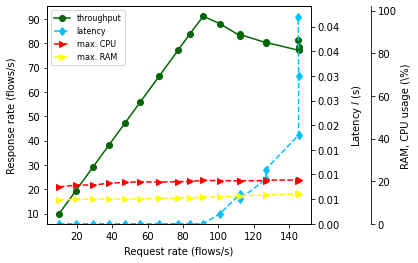

In [32]:
# QoS 0
counter = 1
qos = "qos=0"
runs = []
for x in range(1,19):
    run = get_run(f"data/{qos}/probe_10^{counter}.csv")
    runs.append(run)
    print(f"Experiment {qos}: {counter*10} flows/s, data points: {run.index}, CPU: {run.cpu_mean}%, RAM: {run.ram_mean}%, latency: {run.latency_mean}s/flow, coordinate: ({run.request_slope},{run.response_slope})")  
    counter = counter + 1
df = pd.DataFrame(runs, columns=['request_slope','response_slope','latency_mean','cpu_mean','ram_mean',"index"])
plot_chart(df,qos)

 ### &rarr; The *maximal sustainable throughput* the probe can process for QoS=0 flows is **100 flows/s**

### Quality of Service 1

Experiment qos=1: 10 flows/s, CPU: 17.2%, RAM: 12.27%, latency: 0.58s/flow, coordinate: (9.8821,9.8637)
Experiment qos=1: 20 flows/s, CPU: 17.57%, RAM: 12.44%, latency: 0.51s/flow, coordinate: (19.5255,19.4155)
Experiment qos=1: 30 flows/s, CPU: 18.39%, RAM: 12.47%, latency: 0.62s/flow, coordinate: (29.1856,29.2022)
Experiment qos=1: 40 flows/s, CPU: 18.93%, RAM: 12.58%, latency: 0.65s/flow, coordinate: (38.071,37.9711)
Experiment qos=1: 50 flows/s, CPU: 18.99%, RAM: 12.53%, latency: 0.69s/flow, coordinate: (47.1158,47.1115)
Experiment qos=1: 60 flows/s, CPU: 19.54%, RAM: 12.68%, latency: 0.73s/flow, coordinate: (55.3643,55.3371)
Experiment qos=1: 70 flows/s, CPU: 19.79%, RAM: 12.68%, latency: 0.77s/flow, coordinate: (66.7474,66.7441)
Experiment qos=1: 80 flows/s, CPU: 19.86%, RAM: 12.83%, latency: 2.41s/flow, coordinate: (77.2713,69.973)
Experiment qos=1: 90 flows/s, CPU: 20.0%, RAM: 12.95%, latency: 4.33s/flow, coordinate: (84.075,67.78)
Experiment qos=1: 100 flows/s, CPU: 19.88%, RA

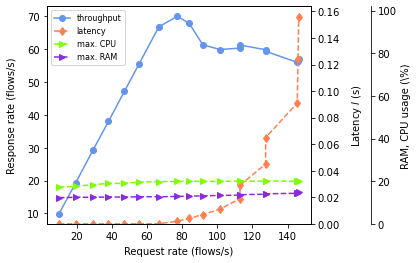

In [26]:
# QoS 1
counter = 1
qos = "qos=1"
runs = []
for x in range(1,19):
    run = get_run(f"data/{qos}/probe_10^{counter}.csv")
    runs.append(run)
    print(f"Experiment {qos}: {counter*10} flows/s, CPU: {run.cpu_mean}%, RAM: {run.ram_mean}%, latency: {run.latency_mean}s/flow, coordinate: ({run.request_slope},{run.response_slope})")  
    counter = counter + 1
df = pd.DataFrame(runs, columns=['request_slope','response_slope','latency_mean','cpu_mean','ram_mean',"index"])
plot_chart(df,qos)

 ### &rarr; The *maximal sustainable throughput* the probe can process for QoS=1 flows is **70 flows/s**

### Quality of Service 2

Experiment qos=2: 10 flows/s, CPU: 16.93%, RAM: 12.29%, latency: 0.64s/flow, coordinate: (9.884,9.9128)
Experiment qos=2: 20 flows/s, CPU: 17.99%, RAM: 12.44%, latency: 0.66s/flow, coordinate: (19.5511,19.6434)
Experiment qos=2: 30 flows/s, CPU: 18.61%, RAM: 12.44%, latency: 0.71s/flow, coordinate: (29.3682,29.3619)
Experiment qos=2: 40 flows/s, CPU: 18.75%, RAM: 12.63%, latency: 0.78s/flow, coordinate: (38.3076,38.3828)
Experiment qos=2: 50 flows/s, CPU: 19.54%, RAM: 12.71%, latency: 1.3s/flow, coordinate: (47.5388,46.3919)
Experiment qos=2: 60 flows/s, CPU: 19.77%, RAM: 12.84%, latency: 5.77s/flow, coordinate: (55.8274,42.0792)
Experiment qos=2: 70 flows/s, CPU: 19.74%, RAM: 12.95%, latency: 12.4s/flow, coordinate: (67.1719,38.3318)
Experiment qos=2: 80 flows/s, CPU: 19.84%, RAM: 13.22%, latency: 25.39s/flow, coordinate: (77.467,34.374)
Experiment qos=2: 90 flows/s, CPU: 19.71%, RAM: 13.5%, latency: 50.9s/flow, coordinate: (84.038,33.3381)
Experiment qos=2: 100 flows/s, CPU: 19.73%, 

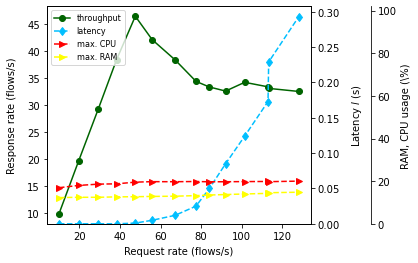

In [31]:
# QoS 1
counter = 1
qos = "qos=2"
runs = []
for x in range(1,15):
    run = get_run(f"data/{qos}/probe_10^{counter}.csv")
    runs.append(run)
    print(f"Experiment {qos}: {counter*10} flows/s, CPU: {run.cpu_mean}%, RAM: {run.ram_mean}%, latency: {run.latency_mean}s/flow, coordinate: ({run.request_slope},{run.response_slope})")  
    counter = counter + 1
df = pd.DataFrame(runs, columns=['request_slope','response_slope','latency_mean','cpu_mean','ram_mean',"index"])
plot_chart(df,qos)

 ### &rarr; The *maximal sustainable throughput* the probe can process for QoS=2 flows is **40 flows/s**